In [1]:
import numpy as np
import pandas as pd
pd.set_option('precision', 10)

import scipy.sparse
import pickle
import xgboost as xgb

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 20,10

import mix as mix
import db_column_name as db

columnName = db.ColumnName()

def modify(df):
    df = df.drop(['min slptend', 'min advRh850', 'min rainc'], axis=1)
    df.set_index('actual_date', inplace=True)
    df = df[[x for x in df.columns if 'min' in x or x == columnName.value]]
    return mix.clean_dataset(df)
    
X_train = pd.read_csv('./date/X_train.csv')
X_train
X_train = modify(X_train)

X_test = pd.read_csv('./date/X_test.csv')
X_test = modify(X_test)

X_train, target_train = mix.getTarget(X_train)
X_test, target_test = mix.getTarget(X_test)

print("Size train {}".format(X_train.shape))
print("Size train {}".format(X_test.shape))


Size train (1043, 51)
Size train (153, 51)


In [2]:
default_params = {
    'verbosity':0,
    'max_depth': 3,
#     # add random 
    'subsample': 0.7,
    'random_state': 42,  
    
    'n_estimators' : 162,
    'learning_rate': 0.1,

}


reg = xgb.XGBRegressor(**default_params)

reg.fit(X_train, target_train[[columnName.value]], eval_metric='rmse')
#         eval_set=[(X_test, target_test[[columnName.value]])], early_stopping_rounds=50) 

target_test['XGB prediction'] = reg.predict(X_test)
#                                             ntree_limit=reg.best_ntree_limit)
target_train['XGB prediction'] = reg.predict(X_train)

mix.print_mean(target_test, target_train, columnName.value, 'XGB prediction')

Mean squared error on train 2.5904120542413476 and test 13.838958781722601
Mean absolute error on train 1.2285026565094121 and test 2.783519684684043
Explained variance score on train 0.9848559440159995 and test 0.8659536378741897
Coefficient of determination on train 0.9848558668756926 and test 0.8639917333905383
Median absolute error on train 0.9848558668756926 and test 0.8639917333905383


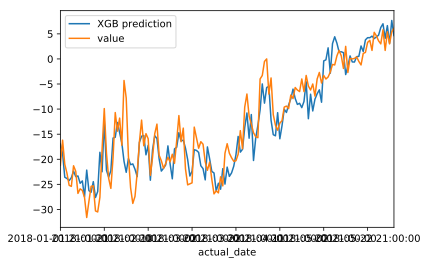

In [3]:
target_test[['XGB prediction', columnName.value]].plot()

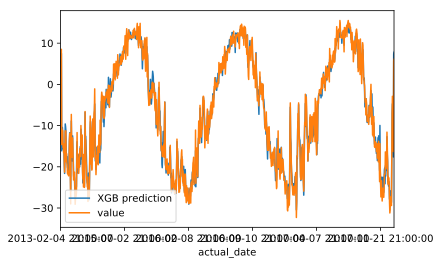

In [6]:
target_train[['XGB prediction', columnName.value]].plot()

In [7]:
# fig, ax = plt.subplots(figsize=(20, 7))
# xgb.plot_importance(reg, ax=ax);

In [8]:
# from sklearn.model_selection import validation_curve
# from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# n_estimators_range = np.linspace(0.09, 0.2, num=50)

# train_scores, test_scores = validation_curve(
#     xgb.XGBRegressor(max_depth=3,subsample=0.7,random_state=42,n_estimators=153),
#     X_test, target_test[[columnName.value]],
#     param_name = 'learning_rate',
#     param_range = n_estimators_range,
#     cv=TimeSeriesSplit(n_splits=10))


# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# fig = plt.figure(figsize=(10, 6), dpi=100)

# plt.title("Validation Curve with XGBoost ")
# plt.xlabel("gamma")
# plt.ylabel("Accuracy")
# plt.ylim(0.5, 1.01)

# plt.plot(n_estimators_range,
#              train_scores_mean,
#              label="Training score",
#              color="r")

# plt.plot(n_estimators_range,
#              test_scores_mean, 
#              label="Cross-validation score",
#              color="g")

# plt.fill_between(n_estimators_range, 
#                  train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, 
#                  alpha=0.2, color="r")

# plt.fill_between(n_estimators_range,
#                  test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std,
#                  alpha=0.2, color="g")

# plt.axhline(y=1, color='k', ls='dashed')

# plt.legend(loc="best")
# plt.show()
# i = np.argmax(test_scores_mean)
# print("Best cross-validation result ({:.2f}) obtained for {} n_estimators".format(test_scores_mean[i],n_estimators_range[i]))

In [10]:
# xgb_model = xgb.XGBRegressor(max_depth=3,subsample=0.7,random_state=42,)
# xgb_grid = GridSearchCV(xgb_model,
#                    {'n_estimators': range(50, 170, 2)}, verbose=1, cv=TimeSeriesSplit(n_splits=10))
# xgb_grid.fit(X_train, target_train[[columnName.value]])

# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)
# target_test['XGB Gride'] = xgb_grid.predict(X_test)
# target_train['XGB Gride'] = xgb_grid.predict(X_train)
# mix.print_mean(target_test, target_train, columnName.value, 'XGB Gride')



In [11]:
# target_test[['XGB Gride', columnName.value]].plot()

In [12]:
# import lightgbm as lgb

# lgb_train = lgb.Dataset(X_train, target_train[[columnName.value]])
# lgb_eval = lgb.Dataset(X_test, target_test[[columnName.value]], reference=lgb_train)

# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': {'l2', 'l1'},
#     'num_leaves': 30,
#     'verbose': 0
# }

# gbm = lgb.train(params,
#                 lgb_train)

# target_test['LightGBG'] = gbm.predict(X_test)
# target_train['LightGBG'] = gbm.predict(X_train)

# mix.print_mean(target_test, target_train, columnName.value, 'LightGBG')

In [13]:
# from sklearn.feature_selection import SelectFromModel
# from numpy import sort

# print(reg.feature_importances_)
# # for thresh in thresholds:
# #     # select features using threshold

# selection = SelectFromModel(reg, threshold=0.007, prefit=True)
# select_X_train = selection.transform(X_train)

# # train model
# selection_model =xgb.XGBRegressor(**default_params)
# selection_model.fit(select_X_train, target_train[[columnName.value]])
# # eval model
# select_X_test = selection.transform(X_test)

# target_test['XGB select'] = selection_model.predict(select_X_test)
# target_train['XGB select'] = selection_model.predict(select_X_train)

# print("Thresh=%.3f, n=%d, " % (thresh, select_X_train.shape[1]))
# mix.print_mean(target_test, target_train, columnName.value, 'XGB select')
    